<a href="https://colab.research.google.com/github/djbradyAtOpticalSciencesArizona/physicsAwareTransformer/blob/master/Inference_as_a_whole_dual_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo notebook for "Wide Field - Narrow Field System"

#### Qian Huang
#### Mar 26, 2023

**Read me before running**
* this notebook requires 21G GPU RAM or more to run.
* Run section 1, then restart runtime, then run section 2.

In [ ]:
### download required files

! git clone https://github.com/djbradyAtOpticalSciencesArizona/physicsAwareTransformer.git
! mv physicsAwareTransformer/PAT/* .
! unzip data/061622_dual_vision_more_patches.zip

In [ ]:
### generate physical receptive field per pixel along epipolar line

! python gen_dataset.py

## Section 1

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from PIL import Image

In [ ]:
from models import *
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from utils import *
import argparse
import os
from torchvision import transforms

/root/anaconda3/envs/imaginaire/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
### load two source images.
### allied_2.png: image from mono camera, 25mm fl
### hr1.png: patch from color camera, 5mm fl

path = '.'
img0 = Image.open(f'{path}/allied_2.png')
img1 = Image.open(f'{path}/hr1.png')

### split large image into 4 to save memory

img0_0  = np.array(img0,  dtype=np.float32)[:1800, :2400, np.newaxis].repeat(3, axis=2)
img0_1  = np.array(img0,  dtype=np.float32)[:1800, -2400:, np.newaxis].repeat(3, axis=2)
img0_2  = np.array(img0,  dtype=np.float32)[-1800:, :2400, np.newaxis].repeat(3, axis=2)
img0_3  = np.array(img0,  dtype=np.float32)[-1800:, -2400:, np.newaxis].repeat(3, axis=2)
img1 = np.array(img1, dtype=np.float32)
img_rights = [img1]
img0.size

(4024, 3036)

In [ ]:
### convert numpy images to tensors

def toTensor(img):
    img = torch.from_numpy(img.transpose((2, 0, 1)))
    return img.float().div(255)

x_left0 = toTensor(img0_0).unsqueeze(0).to('cuda')
x_left1 = toTensor(img0_1).unsqueeze(0).to('cuda')
x_left2 = toTensor(img0_2).unsqueeze(0).to('cuda')
x_left3 = toTensor(img0_3).unsqueeze(0).to('cuda')
x_rights = [toTensor(img_right).unsqueeze(0).to('cuda') for img_right in img_rights]

In [ ]:
### load model

net = PAT(1, in_channel=3, num_input=2).to('cuda')
net = nn.DataParallel(net)
net.eval()
cudnn.benchmark = True
pretrained_dict = torch.load('log_2inputs/x4/best.pth.tar')
net.load_state_dict(pretrained_dict['state_dict'])

<All keys matched successfully>

In [ ]:
### compute initial sub-features

with torch.no_grad():
    x_left0 = net.module.init_feature(x_left0)
    x_left1 = net.module.init_feature(x_left1)
    x_left2 = net.module.init_feature(x_left2)
    x_left3 = net.module.init_feature(x_left3)
    

In [ ]:
### combine splitted features

x_up = torch.cat((x_left0[..., :2012], x_left1[..., -2012:]), dim=3)
x_down = torch.cat((x_left2[..., :2012], x_left3[..., -2012:]), dim=3)
x_left = torch.cat((x_up[:,:,:1518,:], x_down[:,:,-1518:,:]), dim=2).contiguous()
x_left.size()

torch.Size([1, 64, 3036, 4024])

In [ ]:
### compute Q, K (Ss), V (Rs) for transformer

with torch.no_grad():
#     x_left = net.module.init_feature(x_left)
    x_rights = [net.module.init_feature(x_right) for x_right in x_rights]
    buffer_left = net.module.pam.rb(x_left)
    buffer_rights = [net.module.pam.rb(x_right) for x_right in x_rights]
    Q = net.module.pam.b1(buffer_left)
    Ss, Rs = [], []
    for i in range(len(buffer_rights)):
        Ss.append(net.module.pam.b2s[i](buffer_rights[i]))
        Rs.append(net.module.pam.b3s[i](buffer_rights[i]))

In [ ]:
### compute output
### Require ~21G GPU Memory

with torch.no_grad():
    fused_feature = torch.zeros((1, 128, 3036, 4024)).float()
    for i in range(132):
        for j in range(8):
            ID = i*8+j+1
            #print(ID)
            xl, xu, yl, yu = i*23, i*23+23, j*503, j*503+503
            
            Q_ = Q[:, :, xl:xu,yl:yu].contiguous()
            Pos = []

            xxs = np.load('{}/xxs_{:04d}.npy'.format(path, ID))[np.newaxis]
            yys = np.load('{}/yys_{:04d}.npy'.format(path, ID))[np.newaxis]
            Pos.append((torch.from_numpy(xxs), torch.from_numpy(yys)))

            buffers = []
            for S, R, Po in zip(Ss, Rs, Pos):
#                 print(Q_.size(), S.size(), R.size(), Po[0].size())
                buffer, _ = net.module.pam.fe_pam(Q_, S, R, Po, False)
                buffers.append(buffer)
            buffers.append(x_left[:,:,xl:xu,yl:yu])
            fused_feature[:,:,xl:xu,yl:yu] = torch.cat(tuple(buffers), 1).detach()
    #out = net.module.pam.fusion(fused_feature)
#     out = net.module.upscale(out)

In [ ]:
### save fused_feature to avoid OOM

torch.save(fused_feature, 'fused_feature.pt')

## Section 2:

(make sure the runtime has been restarted.)

In [ ]:
### reload modules and PAT

import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from PIL import Image
from models import *
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from utils import *
import argparse
import os
from torchvision import transforms

net = PAT(1, in_channel=3, num_input=2).to('cuda')
net = nn.DataParallel(net)
net.eval()
cudnn.benchmark = True
pretrained_dict = torch.load('log_2inputs/x4/best.pth.tar')
net.load_state_dict(pretrained_dict['state_dict'])

/root/anaconda3/envs/imaginaire/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<All keys matched successfully>

In [ ]:
### reload fused_feature and move to cuda device

fused_feature=torch.load('fused_feature.pt').cuda()

In [ ]:
### finish remaining operations

with torch.no_grad():
    out = net.module.pam.fusion(fused_feature)
    out = net.module.upscale(out)

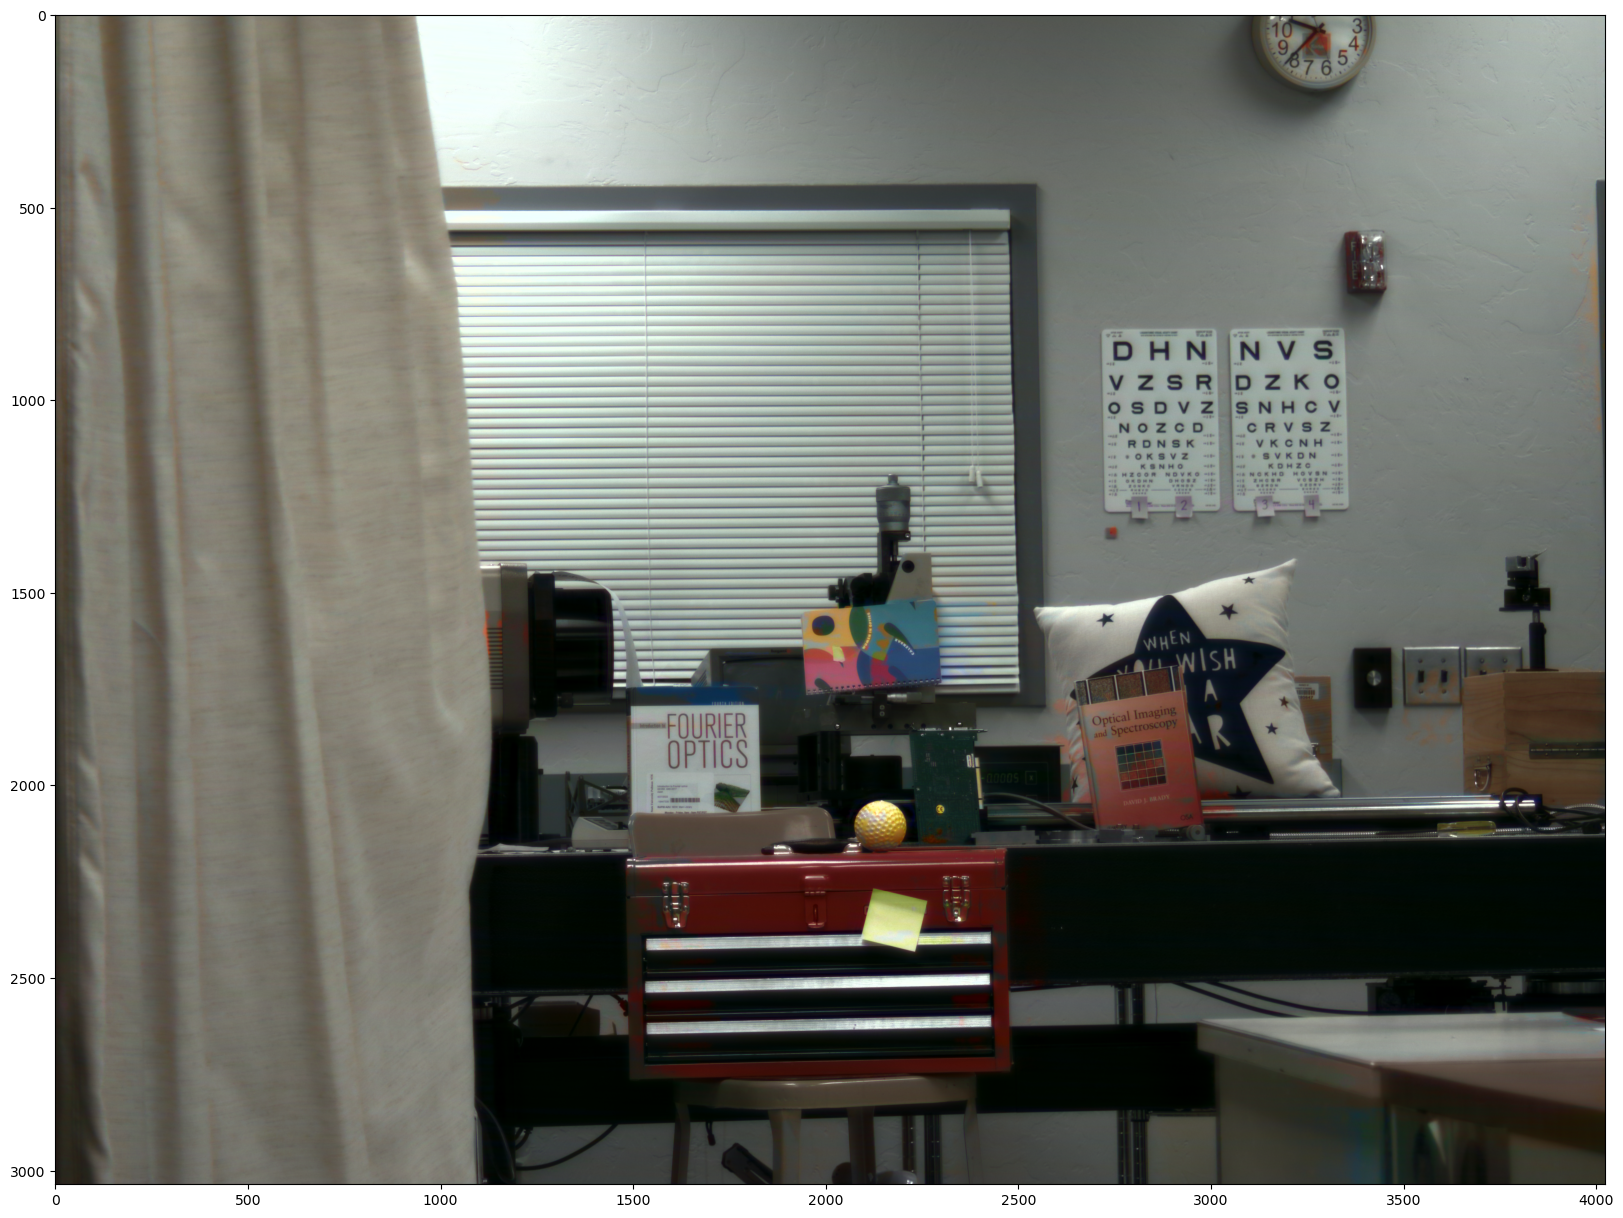

In [ ]:
img = torch.clamp(out, 0, 1).squeeze().cpu().numpy().transpose(1, 2, 0)
plt.figure(figsize=(20,16))
plt.imshow(img)
plt.show()

In [ ]:
cv2.imwrite(f'results/061622_dual_vision_more_patches_asawhole_x4.png', img[..., ::-1]*255.0)

True